In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-09-08 20:47:20 INFO ####################################################################################################


# infer

In [3]:
##################################################################
#
# load data and net
#
##################################################################
# Dasetset  
config_file_path = "/home/lbu/project/PINN_DE/configs/train/slider_crank/config_pirnn.py"
config = read_config_file(config_file_path)
config.dataset_path = "/home/lbu/project/PINN_DE/outputs/data/DynamicSliderCrankDAE"
config.load_net_path = "/home/lbu/project/PINN_DE/outputs/task_slider_crank_pirnn/train-model.pkl"

data_args = {
    "config": config,
    "logger": logger,
}
data = ln.data.get_data(**data_args)
train_loader, val_loader = data
y0, y, yt, data_t, physics_t = next(iter(val_loader))

# Net 
net_args = {
    "config": config,
    "logger": logger,
}
net = ln.nn.get_model(**net_args)

2023-09-08 20:47:20 INFO =================>
2023-09-08 20:47:20 INFO Start get dataset...
2023-09-08 20:47:20 INFO Loading dataset from path: /home/lbu/project/PINN_DE/outputs/data/DynamicSliderCrankDAE
2023-09-08 20:47:20 INFO DynamicRnnData is loaded
2023-09-08 20:47:20 INFO =================>
2023-09-08 20:47:20 INFO Start get models...
2023-09-08 20:47:20 INFO PIRNN loaded
2023-09-08 20:47:20 INFO Number of parameters in model: 1720
2023-09-08 20:47:20 INFO Network loaded from '/home/lbu/project/PINN_DE/outputs/task_slider_crank_pirnn/train-model.pkl'


Successfully loaded pretrained weights from "/home/lbu/project/PINN_DE/outputs/task_slider_crank_pirnn/train-model.pkl"


In [4]:
################################
#
# data processing
#
################################

print('data shape: ')
print(y0.shape, y.shape, yt.shape, data_t.shape, physics_t.shape)

physics_t_list = []
y_list = []
yt_list = []
data_t_list = []
for k in range(6):
    print(k)
    
    split_len = 100
    physics_t_list.append(physics_t[k*split_len: (k+1)*split_len])
    data_t_list.append(data_t[k*split_len: (k+1)*split_len])
    y_list.append(y[k*split_len: (k+1)*split_len])
    yt_list.append(yt[k*split_len: (k+1)*split_len])

physics_t = physics_t[0:101]
y = torch.cat(y_list, dim=0)
yt = torch.cat(yt_list, dim=0)

print('data processing after shape:')
print(y0.shape, y.shape, yt.shape, data_t.shape, physics_t.shape)


data shape: 
torch.Size([6, 14]) torch.Size([606, 14]) torch.Size([606, 14]) torch.Size([606, 1]) torch.Size([606, 1])
0
1
2
3
4
5
data processing after shape:
torch.Size([6, 14]) torch.Size([600, 14]) torch.Size([600, 14]) torch.Size([606, 1]) torch.Size([101, 1])


In [5]:
bs = y.shape[0]
dof = 7

y0_input = y0[0].view(1, -1)
print(y0_input)

q_hat = np.zeros((bs, dof))
qt_hat = np.zeros((bs, dof))
qtt_hat = np.zeros((bs, dof))

for k in range(0, 6):
    time_len = physics_t.shape[0] - 1

    q_hat_k, qt_hat_k, qtt_hat_k = net.get_q_qt_qtt(physics_t, y0_input)

    y0_q_hat = q_hat_k[-1].view(1, -1)
    y0_qt_hat = qt_hat_k[-1].view(1, -1)
    y0_input = torch.cat([y0_q_hat, y0_qt_hat], dim=-1).clone().detach()
    print('-'*10)
    print(y0_input)

    q_hat_k, qt_hat_k, qtt_hat_k = tensors_to_numpy(
        q_hat_k, qt_hat_k, qtt_hat_k
    )
    q_hat[k * time_len : (k + 1) * time_len] = q_hat_k[:-1]
    qt_hat[k * time_len : (k + 1) * time_len] = qt_hat_k[:-1]
    qtt_hat[k * time_len : (k + 1) * time_len] = qtt_hat_k[:-1]

    if k < 5:
        # y0_input = y0[k+1].view(1, -1)
        print(y0[k+1].view(1, -1))


tensor([[ 0.2500,  0.4330,  1.0472,  1.2500,  0.4330, -0.5236,  2.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)
----------
tensor([[ 0.5004, -0.0486, -0.0923,  1.8642, -0.0482,  0.0531,  2.7281, -0.2199,
         -2.5767, -5.1623, -0.5663, -2.5765,  2.9745, -0.6947]],
       device='cuda:0', dtype=torch.float64)
tensor([[ 0.4981, -0.0436, -0.0873,  1.8611, -0.0436,  0.0504,  2.7260, -0.2252,
         -2.5725, -5.1647, -0.5800, -2.5725,  2.9743, -0.7097]],
       device='cuda:0', dtype=torch.float64)
----------
tensor([[-0.3616,  0.3518, -3.9216,  0.0750,  0.3522, -0.4203,  0.8730,  0.6086,
          0.6327, -1.7908,  0.9432,  0.6325, -0.8048,  0.6693]],
       device='cuda:0', dtype=torch.float64)
tensor([[-0.3636,  0.3433, -3.8983,  0.0680,  0.3433, -0.4075,  0.8630,  0.6270,
          0.6641, -1.8268,  0.9674,  0.6641, -0.8353,  0.6806]],
       device='cuda:0', dtype=torch.float64)
----------
tensor([[-0.

In [6]:
plot_q_hat = q_hat
plot_qt_hat = qt_hat
plot_qtt_hat = qt_hat

q, qt = np.split(y, 2, axis=-1)
qt, qtt = np.split(yt, 2, axis=-1)
q, qt, qtt = tensors_to_numpy(q, qt, qtt)

t0 = 0.
t1 = 6.
dt = 0.01
plot_data_t = np.arange(t0, t1, dt)

plot_q = q
plot_qt = qt
plot_qtt = qt

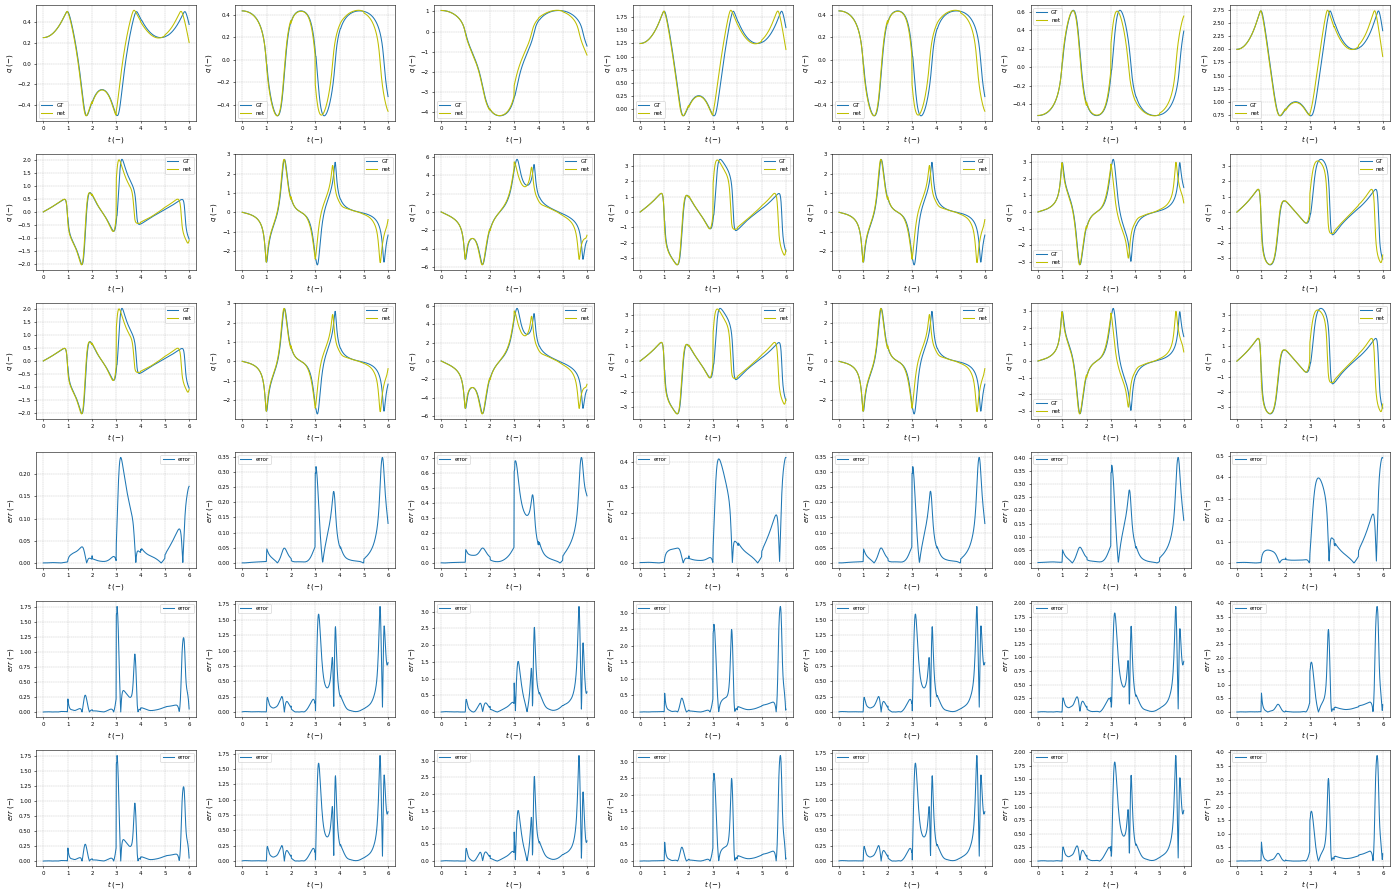

In [7]:
################################
#
# plot result
#
################################

plot_dynamics_metrics(
    config=config,
    pred_data=[plot_q_hat, plot_qt_hat, plot_qtt_hat],
    gt_data=[plot_q, plot_qt, plot_qtt],
    t=plot_data_t,
)